Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing all the required libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

In [6]:
print(tf.__version__)

2.8.2


### Custom function definations

In [7]:
def class_count(directory):
    
    count_of_image_per_class= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count_of_image_per_class.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    
    name_of_classes = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(name_of_classes,count_of_image_per_class)),columns =['Class_Names', 'Image_Count'])

# Data Reading/Data Understanding

### Defining the path for train and test images

In [8]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_Assignment/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_Assignment/Test")

### Checking the number of images in the train and test folders respectively

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'image_count_train = {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'image_count_test = {image_count_test}')

image_count_train = 2239
image_count_test = 118


# Dataset Creation

Creating train & validation dataset from the train directory with a batch size of 32. Also, resizing the images to 180*180.

In [10]:
batch_size = 32 # this variable will be used to specify the batch size later on in the code
# variables to resize the image
img_height = 180
img_width = 180

In [11]:
# creating train datset from the train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
# creating validation datset from the train directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# listing out all the classes of skin cancer and store them in a list.
# these correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset Visualisation

Code to visualize one instance of all the nine classes present in the dataset 

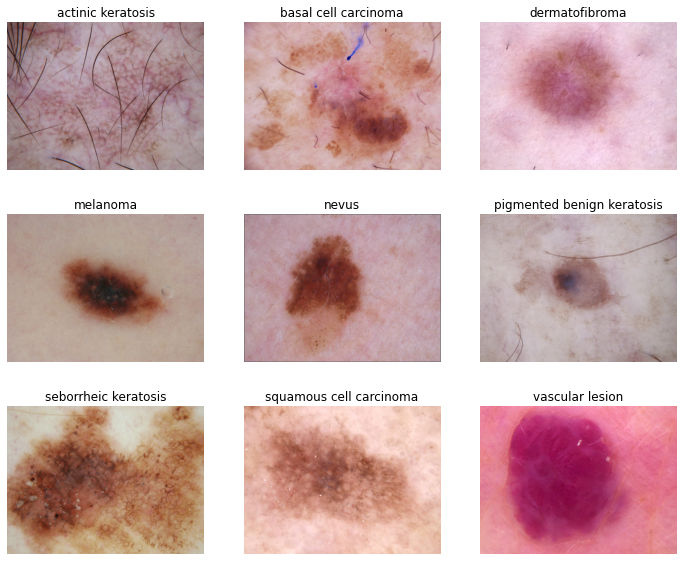

In [14]:
plt.figure(figsize=(12, 10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis("off")
plt.show()

# Model Building and Training



*   Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
*   Choose an appropriate optimiser and loss function for model training
*   Train the model for ~20 epochs
*   Write your findings after the model fit, see if there is evidence of model overfit or underfit





### Configuring the dataset for performance

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating a CNN model

Creating a CNN model for detecting 9 classes present in the dataset. Also, since the images are of RGB in nature so, normalization will be done as the RGB channel values are in the [0, 255] range and is not ideal for a neural network.

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the Model

Selecting an appropirate optimiser and loss function for model training

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Viewing all the layers of the model

### Checking the model Summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the Model

In [19]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 265s 931ms/step - loss: 1.9069 - accuracy: 0.3064 - val_loss: 2.1064 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5845 - accuracy: 0.4436 - val_loss: 1.4654 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3904 - accuracy: 0.5123 - val_loss: 1.3903 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3304 - accuracy: 0.5318 - val_loss: 1.3273 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1992 - accuracy: 0.5859 - val_loss: 1.3458 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1488 - accuracy: 0.5982 - val_loss: 1.3673 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0710 - accuracy: 0.6116 - val_loss: 1.4371 - val_accuracy: 0.5190
Epoch 8/20

### Visualizing the Training Result

Creating plots of loss and accuracy on the training and validation data

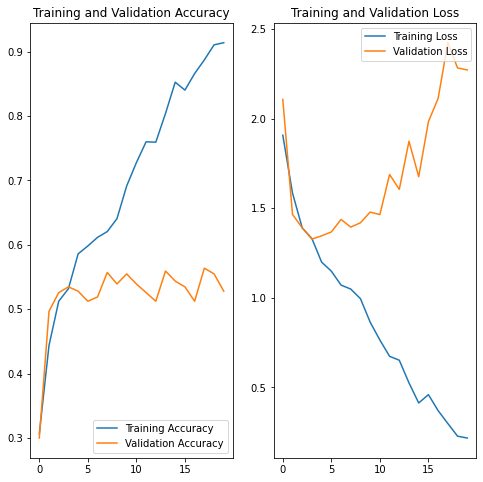

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

Based on the accuracy score(\~90%) and validation score (\~50%) it is inferred that the model is overfitting.

We will do further pre-processing to mitigate the issue.

# Data Augmentation Strategy 

Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

### Augmenting the data

In [21]:
augmented_data = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=123, input_shape=(img_height,img_width,3)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2)
])

### Visualizing the data after augmentation

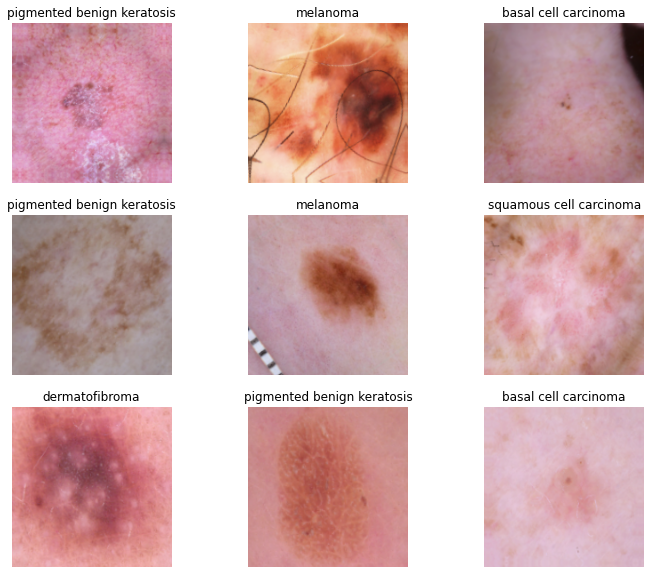

In [22]:
# visualizing some random samples of data after augmentation

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_data(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Model Building & training on the augmented data


*   Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
*   Choose an appropriate optimiser and loss function for model training
*   Train the model for ~20 epochs
*   Write your findings after the model fit, see if the earlier issue is resolved or not?



### Creating a CNN model with data augmentation (without Dropout)

In [23]:
num_classes = len(class_names)

model_augmented = Sequential([
  augmented_data,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the new CNN model after data augmentation (without Dropout)

In [24]:
model_augmented.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Checking the model Summary after data augmentation (without Dropout)

In [25]:
model_augmented.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model on augmented data (without Dropout)

In [26]:
epochs_augmented = 20
history_augmented = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_augmented
)

Epoch 1/20
56/56 [==============================] - 3s 31ms/step - loss: 2.2146 - accuracy: 0.2422 - val_loss: 1.9018 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.8943 - accuracy: 0.3025 - val_loss: 1.7869 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7448 - accuracy: 0.3622 - val_loss: 1.7946 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6594 - accuracy: 0.4007 - val_loss: 1.7141 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5820 - accuracy: 0.4342 - val_loss: 1.5386 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5361 - accuracy: 0.4470 - val_loss: 1.4935 - val_accuracy: 0.4452
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4750 - accuracy: 0.4888 - val_loss: 1.4146 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing the Training Result after data augmentation (without Dropout)

Creating plots of loss and accuracy on the training and validation data

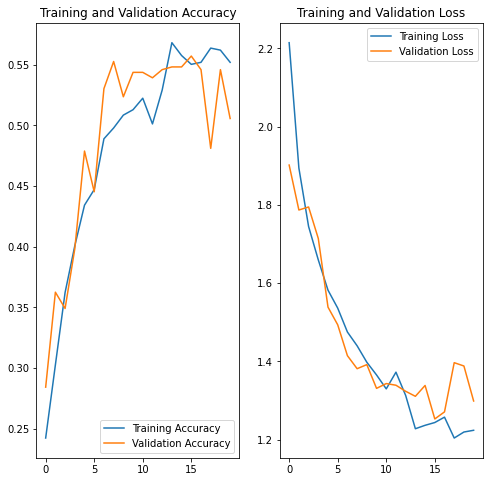

In [27]:
acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']

loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

epochs_range = range(epochs_augmented)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Creating a CNN model with data augmentation (with Dropout)

In [28]:
num_classes = len(class_names)

model_augmented_dropout = Sequential([
  augmented_data,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.30),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the new CNN model after data augmentation (with Dropout)

In [29]:
model_augmented_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Checking the model Summary after data augmentation (with Dropout)

In [30]:
model_augmented_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model on augmented data (with Dropout)

In [31]:
epochs_augmented_dropout = 20
history_augmented_dropout = model_augmented_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_augmented_dropout
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 1.9398 - accuracy: 0.3080 - val_loss: 1.8513 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.6747 - accuracy: 0.4029 - val_loss: 1.5298 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5107 - accuracy: 0.4509 - val_loss: 1.5351 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4521 - accuracy: 0.4866 - val_loss: 1.4326 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3670 - accuracy: 0.5145 - val_loss: 1.3491 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3610 - accuracy: 0.5106 - val_loss: 1.3520 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3294 - accuracy: 0.5312 - val_loss: 1.3889 - val_accuracy: 0.5145
Epoch 8/20
56

### Visualizing the Training Result after data augmentation (with Dropout)

Creating plots of loss and accuracy on the training and validation data

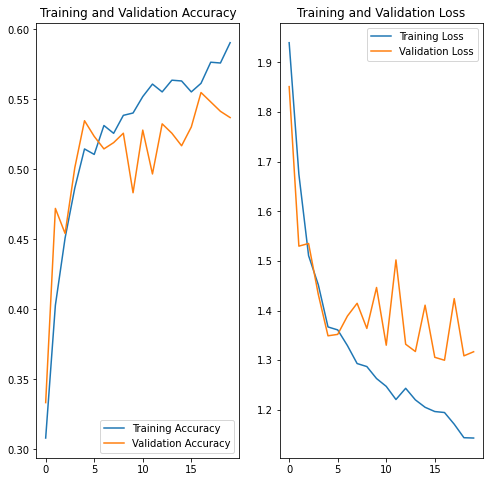

In [32]:
acc = history_augmented_dropout.history['accuracy']
val_acc = history_augmented_dropout.history['val_accuracy']

loss = history_augmented_dropout.history['loss']
val_loss = history_augmented_dropout.history['val_loss']

epochs_range = range(epochs_augmented)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after data augmentation

After data augmentation through horizontal and vertical flipping the model isn't overfitting anymore but the accuracy is at a meager \~58% for train data and \~55% for validation data irrespective of the architecture.

I guess the main issue is of class imbalance, there may be disproportionate amount of images per class to learn from.

We will do further pre-processing to mitigate the issue.

# Class Distribution

Examining the current class distribution in the training dataset.

In [41]:
df_cancer_class = class_count(data_dir_train)
df_cancer_class.sort_values('Image_Count', axis=0, ascending=False, inplace=True)

In [42]:
df_cancer_class

,Class_Names,Image_Count
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


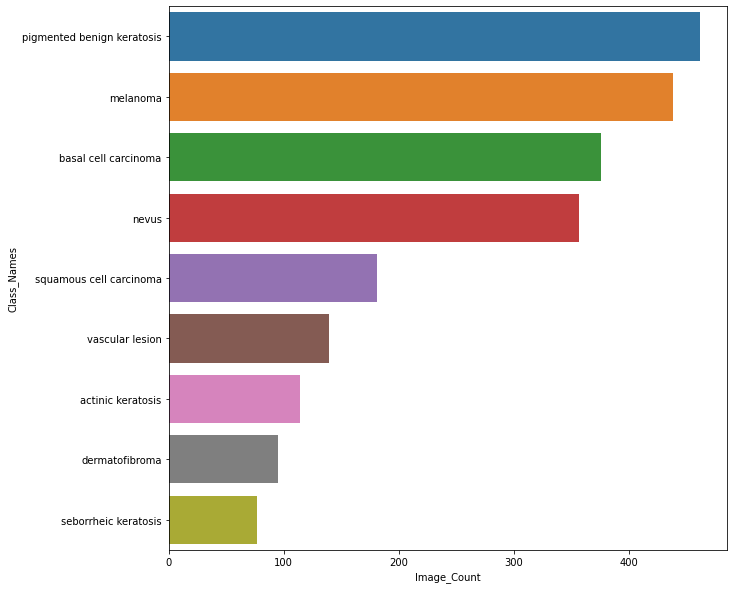

In [47]:
plt.figure(figsize=(10, 10))
sns.barplot(x="Image_Count", y="Class_Names", data=df_cancer_class)
plt.show()

**Question:** Which class has the least number of samples?

**Answer:** Seborrheic Keratosis

**Question:** Which classes dominate the data in terms of the proportionate number of samples?

**Answer:** Pigmented Benign Keratosis

# Handling class imbalances

Rectifying class imbalances present in the training dataset with [Augmentor](https://augmentor.readthedocs.io/en/master/) library.

In [48]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [50]:
path_to_training_dataset="/content/drive/MyDrive/CNN_Assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB28CB98C90>: 100%|██████████| 500/500 [00:18<00:00, 26.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB2860EFB50>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB320E9D510>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=960x724 at 0x7FB28D006590>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB320FB4A10>: 100%|██████████| 500/500 [01:27<00:00,  5.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB28CF6E550>: 100%|██████████| 500/500 [00:18<00:00, 27.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB31006E310>: 100%|██████████| 500/500 [00:41<00:00, 12.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB310103BD0>: 100%|██████████| 500/500 [00:18<00:00, 27.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB320E51DD0>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


# Model Building and Training on the rectified class imbalance data

Creating a CNN model, to detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).


### Dataset Creation

In [68]:
# creating train datset from the train directory after handling class imbalance
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [69]:
# creating validation datset from the train directory after handling class imbalance
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating CNN model

Using the same vanilla model that was created initialy before any kind of data preprocessing

In [73]:
num_classes = len(class_names)

model_rebalanced = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [74]:
model_rebalanced.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Checking the model summary

In [75]:
model_rebalanced.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Training the model

In [77]:
epochs_rebalanced=30
history_rebalanced = model_rebalanced.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_rebalanced
)

Epoch 1/30
169/169 [==============================] - 32s 182ms/step - loss: 1.7965 - accuracy: 0.3208 - val_loss: 1.5094 - val_accuracy: 0.4328
Epoch 2/30
169/169 [==============================] - 30s 173ms/step - loss: 1.3681 - accuracy: 0.4872 - val_loss: 1.3235 - val_accuracy: 0.5063
Epoch 3/30
169/169 [==============================] - 30s 173ms/step - loss: 1.1739 - accuracy: 0.5684 - val_loss: 1.1950 - val_accuracy: 0.5612
Epoch 4/30
169/169 [==============================] - 30s 172ms/step - loss: 1.0204 - accuracy: 0.6254 - val_loss: 1.0480 - val_accuracy: 0.6169
Epoch 5/30
169/169 [==============================] - 31s 181ms/step - loss: 0.8824 - accuracy: 0.6814 - val_loss: 1.0412 - val_accuracy: 0.6199
Epoch 6/30
169/169 [==============================] - 31s 177ms/step - loss: 0.7090 - accuracy: 0.7455 - val_loss: 0.8733 - val_accuracy: 0.6934
Epoch 7/30
169/169 [==============================] - 30s 172ms/step - loss: 0.5923 - accuracy: 0.7915 - val_loss: 0.8675 - val_ac

### Visualizing the Training Result

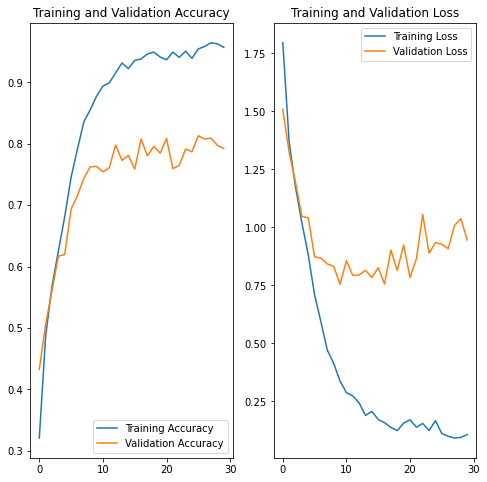

In [78]:
acc = history_rebalanced.history['accuracy']
val_acc = history_rebalanced.history['val_accuracy']

loss = history_rebalanced.history['loss']
val_loss = history_rebalanced.history['val_loss']

epochs_range = range(epochs_rebalanced)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after handling class imbalance

Finally we could handle both overfitting and class imbalance issue and the model performance has increased considerably, train accuracy is now at \~95% and validation accuracy is now at \~80%